### Libraries

In [ ]:
# !pip install langchain==0.1.7 --quiet
!pip install langchain==0.1.10 --quiet
!pip install transformers --quiet
!pip install sentence-transformers --quiet
!pip install chromadb --quiet
!pip install pypdf --quiet
!pip install openai --quiet
!pip install langchain-openai --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.2/806.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

**Package related issues**
* `langchain > 0.1.7` might give error on `.invoke()` while working with HuggingFace Models
* Shows deprecation warning if `langchain.chat_models import ChatOpenAI` is used.

In [ ]:
import os
import langchain
import transformers
import sentence_transformers

from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.document_loaders import TextLoader, PyPDFLoader, PyPDFDirectoryLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma


from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer,
AutoModelForQuestionAnswering, AutoConfig, AutoModel, T5Tokenizer, T5ForConditionalGeneration

from google.colab import drive
drive.mount('/content/drive')

print(f"langchain version: {langchain.__version__}")

Mounted at /content/drive
langchain version: 0.1.10


### RAG: Retrieval-Augmented Generation<br>


Basic architecture for question-answering pipeline with external knowledge base. RAG model augments the user input (or prompts) by adding the relevant retrieved data in context. This step uses prompt engineering techniques to communicate effectively with the LLM. The augmented prompt allows the large language models to generate an accurate answer to user queries.


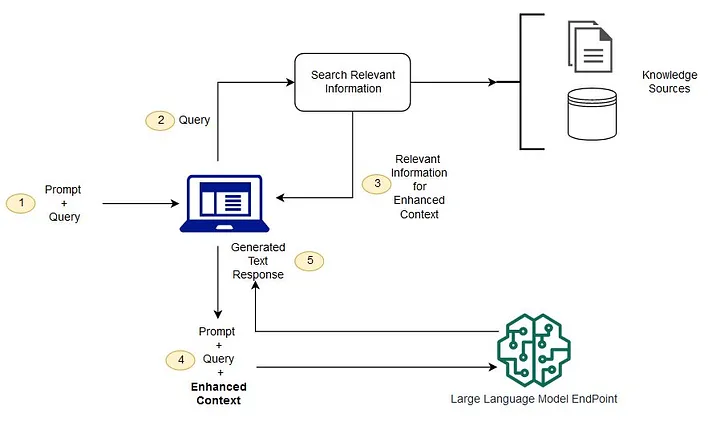

#### Exploration of langchain and it's components to generate answer for questions with context
* Document loaders, splitting and chunking
* Basic vector database and sementic similarity search with embeddings
* Integration with Huggingface embeddings, llm models, pipelines and inference
* Integration with OPENAI API llm model inference


In [ ]:
doc_directory = '/content/drive/MyDrive/Colab Notebooks/RAG_Doc_QA/'

# Use the following line for loading .txt/.md files
# loader = TextLoader(doc_directory+"sample_input2.pdf")

# Use the following lines for loading .pdf files
loader = PyPDFLoader(doc_directory+"7.pdf")
docs = loader.load_and_split()

# loader = PyPDFDirectoryLoader(doc_directory)
# docs = loader.load() # will auto split into pages
print(f"Total Pages: {len(docs)}")

Total Pages: 28


In [ ]:
texts = docs

#The following is for .txt files
text_splitter = CharacterTextSplitter(chunk_size=100, chunk_overlap=0)

texts = text_splitter.split_documents(docs)

### Embeddings & vector storage

We can use different model for document vector storage and retrieval as the model being used for text generation might be missing sentence-transformer embeddings.

In [ ]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

In [ ]:
to_embed_texts = []
for i in range(len(texts)):
    to_embed_texts.append(texts[i].page_content)

embedded_texts = hf_embeddings.embed_documents(to_embed_texts)
print(len(embedded_texts), len(embedded_texts[0]))

doc_vector_db = Chroma.from_documents(texts, hf_embeddings)


28 768


### Model & pipeline definition

#### Huggingface pipeline

In [ ]:
# Specify the model name from hugging face models/
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0" # other model(s) that worked: ["google/flan-t5-large"]

# Create a pipeline instance from HugginFace
# hf_pipe = pipeline(model=model,tokenizer=tokenizer,task='text-generation',max_length=512,repetition_penalty=1.1)
hf_pipe = pipeline("text-generation", model=model_name) # parameters for gpu usage device_map="auto"

# Create an instance of the HuggingFacePipeline, wrapping a huggingface pipeline with additional model-specific arguments
llm_pipeline = HuggingFacePipeline(pipeline=hf_pipe, model_kwargs={"temperature": 0.4, "max_length": 512})

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

### Chat Templates

#### HuggingFace pipeline
Chat templates can be a bit tricky when trying to use with HuggingFace pipeline.<br>
`pipeline.tokenizer.apply_chat_template` returns a `str` created by concatanating the whole dictionary. This `str` then can be passed to langchain's `PromptTemplate.from_template()`. <br>
Otherwise this can lead to this issue: https://github.com/langchain-ai/langchain/issues/15884

In [ ]:
# Use the tokenizer's chat template to format each message - see https://huggingface.co/docs/transformers/main/en/chat_templating
hf_message_template = [
    {
        "role": "system",
        "content": "You are a friendly chatbot, answer. Use the following context if it's available but don't quote from source, phrase in your own words, If you do not know, answer that you don't have knowledge on that. Here is the context: {context}",
    },
    {"role": "user", "content": "{question}"},
]
message_template = hf_pipe.tokenizer.apply_chat_template(hf_message_template, tokenize=False, add_generation_prompt=True)


### Query embedding and context retrieval

Before running model to get response, we first need to retrieve chunk from document by searching for similarity with the query. Query also need to be embedded.

In [ ]:
question = "Can I bring a phone to school ? Are there any restrictions ?"
# question = "What will happen if I misbehave during class ?"
# question = "What if a student is late ? By what time a student should be in class ? be specific."
# question = "Who is the first president of the usa ?"

question_vector = hf_embeddings.embed_query(question)
# print(len(query_vector))


similar_docs = doc_vector_db.similarity_search_by_vector(question_vector, k=1)
# similar_docs

context = similar_docs[0].page_content

# Check which page(s) are returned in similarity search
for split_page in similar_docs:
    print(split_page.metadata)

{'page': 2, 'source': '/content/drive/MyDrive/Colab Notebooks/RAG_Doc_QA/7.pdf'}


In [ ]:
print(context)

7.1 • U NITS 3
Fig. 7.2 shows a ﬁnal schematic of a basic neural unit. In this example the unit
takes 3 input values x1,x2, and x3, and computes a weighted sum, multiplying each
value by a weight ( w1,w2, and w3, respectively), adds them to a bias term b, and then
passes the resulting sum through a sigmoid function to result in a number between 0
and 1.
x1x2x3
yw1w2w3∑bσ+1za
Figure 7.2 A neural unit, taking 3 inputs x1,x2, and x3(and a bias bthat we represent as a
weight for an input clamped at +1) and producing an output y. We include some convenient
intermediate variables: the output of the summation, z, and the output of the sigmoid, a. In
this case the output of the unit yis the same as a, but in deeper networks we’ll reserve yto
mean the ﬁnal output of the entire network, leaving aas the activation of an individual node.
Let’s walk through an example just to get an intuition. Let’s suppose we have a
unit with the following weight vector and bias:
w= [0.2,0.3,0.9]
b=0.5
What would 

### Inference

#### Through langchain pipeline

`PromptTemplate.from_template` expects `str`. So, for HuggingFace Pipeline,
1. First apply `pipeline.tokenizer.apply_chat_template` on message template. It returns a `str`
2. Then create a template from this `str` with lanchain's promptTemplate.
3. **Necessary for `TinyLlama/TinyLlama-1.1B-Chat-v1.0` model**. Other models may differ.

In [ ]:
prompt = PromptTemplate.from_template(message_template)
print(prompt.input_variables)

['context', 'question']


In [ ]:
# this run is for HuggingFace pipelines
query_llm = LLMChain(llm=llm_pipeline, prompt=prompt)
response = query_llm.invoke({"context":context, "question": question})
print(response["text"])

<|system|>
You are a friendly chatbot, answer. Use the following context if it's available but don't quote from source, phrase in your own words, If you do not know, answer that you don't have knowledge on that. Here is the context: 7.1 • U NITS 3
Fig. 7.2 shows a ﬁnal schematic of a basic neural unit. In this example the unit
takes 3 input values x1,x2, and x3, and computes a weighted sum, multiplying each
value by a weight ( w1,w2, and w3, respectively), adds them to a bias term b, and then
passes the resulting sum through a sigmoid function to result in a number between 0
and 1.
x1x2x3
yw1w2w3∑bσ+1za
Figure 7.2 A neural unit, taking 3 inputs x1,x2, and x3(and a bias bthat we represent as a
weight for an input clamped at +1) and producing an output y. We include some convenient
intermediate variables: the output of the summation, z, and the output of the sigmoid, a. In
this case the output of the unit yis the same as a, but in deeper networks we’ll reserve yto
mean the ﬁnal output of